In [218]:
import numpy as np                         # numpy is a library that includes most of the numerical function you will need
import matplotlib.pyplot as plt            # this is the library we use to plot   
from mpl_toolkits.mplot3d import Axes3D    # this is a library to plot in 3d

In [223]:
array1 = np.linspace(0,np.pi,500)
array2 = np.linspace(np.pi,2*np.pi,500)
array3 = np.linspace(-0.40,0.40,500)
array4 = np.ones(500)

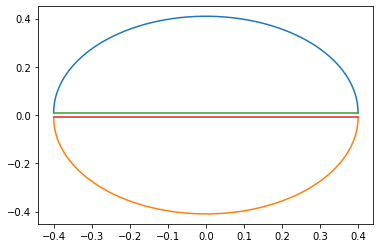

In [224]:
plt.plot(0.40*np.cos(array1),0.40*np.sin(array1)+0.01,0.40*np.cos(array2),0.40*np.sin(array2)-0.01,array3,0.01*array4,array3,-0.01*array4)

In [284]:
def cyclotron_magnetic_field(particle_position,B0,d) :
    ''' This particle position as the arg is in cartesian co-ordinates. B0 is the magnitude of the magnetic
    field in the D-plates of the cyclotron. d is the length of the gap between the 2 D plates. 
    The returned magnetic field is in cartesian co-ordinates. 
    Note: The radius of the cyclotron is set to be 0.4m'''
    
    #These points are set to make it easier to infer if the particle is currently in the D plates or not. 
    position1 = np.array([0,d/2,0])
    position2 = np.array([0,-d/2,0])
    
    
    if particle_position[1]>=d/2:       #This means the particle is above the lower boundary of the upper D plate
        distance = particle_position-position1
        r = np.sqrt((distance[0]**2)+(distance[1]**2))
        
        #This means the particle is outside the upper semi circular D plate.
        if r> 0.4:  
            B = np.array([0,0,0])
        
        #This means the particle is inside the D plate, thus there is a magnetic field oreinted out of the page
        else:   
            B = np.array([0,0,B0])
    
    #This means the particle is lower than the upper boundary of the lower D plate.
    elif particle_position[1]<=-d/2:
        distance = particle_position-position2
        r = np.sqrt((distance[0]**2)+(distance[1]**2))
        
        #This measn the particle is outside the lower D plate
        if r> 0.4:
            B = np.array([0,0,0])
        
        #This measn the particle is inside the lower D plate
        else:
            B = np.array([0,0,B0])
    
    #This means the particle is in the region between the 2 D plates, and thus there is a no magnetic field.
    else:
        B = np.array([0,0,0])
    

    return B

In [285]:
def cyclotron_electric_field(particle_position,t,w,E0,d) :
    '''We have 5 arguments - Particle position in cartesian co-ordinates, time - which is required since we have
    an alternating E-field, w is the angular velocity of the particle, E0 is the maximum magnitude of the electric
    field, and d is the length of the gap between the 2-D plates'''
    
    #This means that the particle is in the region between the 2 D plates, and there is thus an electric field here.
    if -0.4 <= particle_position[0] <= 0.4 and -d/2 <= particle_position[1] <= d/2:
        E = np.array([0,E0*np.cos(w*t),0])  #The magnitude and direction of electric field is alternating, thus 
                                            #there is a cos(wt) to ensure it alternates at the same frequency as the
                                            #particle's circular motion. 
        
    else:
        E = np.array([0,0,0])              #This means the particle is not in the gap, thus electric field is 0.
    return E

In [286]:
def calc_force_on_charge_by_efield(electric_field, q) :
    ''' We have two arguments - electric field vector and charge q.'''
    force = q*electric_field     #Electric field equation described in background section
    return force

def calc_force_on_charge_by_bfield(magnetic_field, charge_velocity, q) :
    ''' 2 arguments and 1 kwarg.  You will need to use np.cross
    from above. Magnetic field and velocity also need to be vectors. '''
    force = q*np.cross(charge_velocity, magnetic_field)   #Lorentz force described in background section
    return force

In [287]:
def calc_acceleration_of_charge_in_ebfields(electric_field, magnetic_field, charge_velocity, q, m) :
    '''We have 5 arguments in this case. Calculate acceleration of a charge in both electric and mag fields. 
    Efield, mag field and charge v need to be vectors.'''
    # we will first calculate the force due to the electric and magnetic fields on the charge:
    eforce = calc_force_on_charge_by_efield(electric_field, q)
    bforce = calc_force_on_charge_by_bfield(magnetic_field, charge_velocity, q)
    netforce = eforce + bforce
    acceleration = netforce/m   #Newton's 2nd Law 
    return acceleration

In [288]:
def get_updated_value(current_value, rate_of_change, dt) :  
    '''3 args - current value of whatever changing parameter, rate of change of that parameter and dt.'''
    updated_value = current_value + (rate_of_change*dt)
    return updated_value

In [289]:
def get_rates_of_change_euler(particle_position, particle_velocity, electric_field_function,
                                        magnetic_field_function, q, m, t, w, E0, B0, d, dt) :
    '''When using Euler's method, the rates of change are simply the cureent particle velocity, and the 
    current acceleration.
    12 args - all have been described above, these args will be used to run functions defined earlier above
    In Eulers Method, the rates of change - which is calculated using net force, is calculated using current 
    values.'''
    
    
    electric_field_at_position = electric_field_function(particle_position,t,w,E0,d)
    magnetic_field_at_position = magnetic_field_function(particle_position,B0,d)
    
    particle_acceleration = calc_acceleration_of_charge_in_ebfields(electric_field_at_position, 
                                                                    magnetic_field_at_position, 
                                                                    particle_velocity, q, m)
    return particle_velocity, particle_acceleration





In [290]:
def get_rates_of_change_runge_kutta(particle_position, particle_velocity, electric_field_function,
                                        magnetic_field_function, q, m, t, w, E0, B0, d, dt) :
    ''' This uses the Runge-Kutta method to calculate the updated value.  This method relies on mid-points.
    Note, this method can replace get_rates_of_change_euler in the argument, get_rates_of_change_function, that
    is input to calc_trajectory_in_fields function defined below. Args are the same as in the Euler Method'''

    current_velocity, current_acceleration = get_rates_of_change_euler(particle_position, particle_velocity, electric_field_function,
                                        magnetic_field_function, q, m, t, w, E0, B0, d, dt)
    
    #Mid particle velocity and position is used to calculate rates of change, to be a little more precise
    mid_particle_velocity = current_velocity + current_acceleration * dt/2
    mid_particle_position = particle_position + mid_particle_velocity * dt/2
    
    # Calculate the acceleration due to the electric and magnetic fields at the mid_particle_position
    runge_kutta_velocity, runge_kutta_acceleration = get_rates_of_change_euler(mid_particle_position, 
                                                                               mid_particle_velocity,
                                                                               electric_field_function, 
                                                                               magnetic_field_function, 
                                                                               q, m, t, w, E0, B0, d, dt)
                                                                        
    return runge_kutta_velocity, runge_kutta_acceleration

In [291]:
def create_place_holder_array(timesteps) :
    ''' Returns a placeholder array. 1 Arg - timesteps because the length of the placeholder array must
    be the same as the number of timesteps.'''
    position_evolution = np.zeros([timesteps.size, 3])
    velocity_evolution = np.zeros([timesteps.size, 3])
    return position_evolution, velocity_evolution

In [293]:
def calc_trajectory_in_fields(electric_field_function, magnetic_field_function, get_rates_of_change_function, 
                              timesteps, particle_position, particle_velocity, q, m, w, E0, B0, d) :
    '''This function takes in functions that output the electric and magnetic fields functions with an argument
    of particle position, time, angular velocity and magnitudes E0 and B0.  
    This also requires as an argument - the timesteps you wish to iterate over, and the initial conditions 
    of the particle_position and particle_velocity it starts out with.  The charge and mass and
    length between plates, d, are also required'''
    
    # Create place holder arrays for position, velocity, kinetic energy and speed.
    position_evolution, velocity_evolution = create_place_holder_array(timesteps)
    kinetic_energy = np.zeros([timesteps.size])
    speed_evolution = np.zeros([timesteps.size])
     
    
    dt = timesteps[1]  # timesteps looks like np.array([0, dt, 2*dt, 3*dt, ...., (total_timesteps-1)*dt])
    for inum, timestep in enumerate(timesteps) :
        # Populate the position, velocity, speed and kinetic energy
        position_evolution[inum,:] = particle_position
        velocity_evolution[inum,:] = particle_velocity
        particle_speed = np.linalg.norm(particle_velocity)
        kin_en = 0.5*m*(particle_speed**2)
        kinetic_energy[inum] = kin_en
        speed_evolution[inum] = particle_speed
        
        # Calculate velocity and acceleration due to e- and b-fields to update particle_position and 
        #particle_velocity. Velocity rate of change stands for acceleration and position rate of change is 
        #velocity
        position_rate_of_change, velocity_rate_of_change = get_rates_of_change_function(particle_position, 
                                                                                        particle_velocity, 
                                                                                        electric_field_function, 
                                                                                        magnetic_field_function, 
                                                                                        q, m, timestep, w, E0, B0, d, dt)
        
        # Update
        particle_position = get_updated_value(particle_position, position_rate_of_change, dt)
        particle_velocity = get_updated_value(particle_velocity, velocity_rate_of_change, dt)
        
    return position_evolution, velocity_evolution, kinetic_energy, speed_evolution
        

In [294]:
def calc_trajectory_in_fields_relativity(electric_field_function, magnetic_field_function, 
                                         get_rates_of_change_function, timesteps, particle_position, 
                                         particle_velocity, q, m, w, E0, B0, d) :
    '''This function takes in functions that output the electric and magnetic fields functions with an argument
    of particle position, time, angular velocity and magnitudes E0 and B0.  
    This also requires as an argument - the timesteps you wish to iterate over, and the initial conditions 
    of the particle_position and particle_velocity it starts out with.  The charge and mass and
    length between plates, d, are also required. The only difference between this function and the non-relativity
    function is that here mass is updated based on the current speed of the particle in the loop.'''
    
    # Create place holder arrays
    position_evolution, velocity_evolution = create_place_holder_array(timesteps)
    c=3*10e+8
    
    kinetic_energy = np.zeros([timesteps.size])
    speed_evolution = np.zeros([timesteps.size])
     
    
    dt = timesteps[1]  # timesteps looks like np.array([0, dt, 2*dt, 3*dt, ...., (total_timesteps-1)*dt])
    for inum, timestep in enumerate(timesteps) :
        # Populate
        position_evolution[inum,:] = particle_position
        velocity_evolution[inum,:] = particle_velocity
        
        particle_speed = np.linalg.norm(particle_velocity)
        
        #gamma factor is the factor in relativity - described in setup section
        gamma = 1/((1-((particle_speed/c)**2))**0.5)
        #mass update
        m = gamma*m
        #kinetic energy calculated based on this new relativistic mass
        kin_en = 0.5*m*(particle_speed**2)
        kinetic_energy[inum] = kin_en
        speed_evolution[inum] = particle_speed
        
                
        # Calculate velocity and acceleration due to e- and b-fields to update particle_position and 
        #particle_velocity. Velocity rate of change stands for acceleration and position rate of change is 
        #velocity
        position_rate_of_change, velocity_rate_of_change = get_rates_of_change_function(particle_position, 
                                                                                        particle_velocity, 
                                                                                        electric_field_function, 
                                                                                        magnetic_field_function, 
                                                                                        q, m, timestep, w, E0, B0, 
                                                                                        d, dt)
        
        # Update
        particle_position = get_updated_value(particle_position, position_rate_of_change, dt)
        particle_velocity = get_updated_value(particle_velocity, velocity_rate_of_change, dt)
        
    return position_evolution, velocity_evolution, kinetic_energy, speed_evolution
        

In [295]:
#Intitial Conditions for the simulation of a hydrogen nucleus in a cyclotron:
m = 3.3436e-27 #mass of hydrogen nucleus

q = 1.602e-19 #charge of hydrogen nucleues - proton charge

B0 = 1.5 #mag field strength in cyclotron

initial_energy = 1.602e-19*30e+3 #This is set based on the cited source in references, since an initial speed is 
                                 #required for the particle in a cyclotron.
    
initial_speed = ((2*initial_energy)/m)**0.5 #speed calculated using kinetic energy defined above.

initial_R = (m*initial_speed)/(q*B0) #Initial Radius of circular motion of the hydrogen nucleus - based on intial
                                     #speed


electric_pd = 50e+3                 #This is set based on paper cited in references section - this is max potential 
                                    #difference due to electric field between plates
    
d = 0.001    #gap length between the 2 D plates of cyclotron
E0 = electric_pd/d   #Maximum electric field strength, calculated using eqn defined in background section, V = Ed

w = (q*B0)/m   #Angular velocity of nucleus in D plates, given by eqn defined in background

In [296]:
initial_position = np.array([-initial_R,0,0]) #Set using radius of circular path defined by initial speed.
initial_velocity = np.array([0,initial_speed,0]) #Along the y-direction - in the direction of initial E-field,
    
dt = 1e-6/50000    #set after troubleshooting and finding suitable dt
timesteps = np.arange(0, 2.5e-5, dt)  

In [297]:
#Trajectory of hydrogen nucleus calculated using non-relativstic function

trajectory_cyclotron_nonrel, velocity_cyclotron_nonrel, kinetic_nonrel, speed_nonrel = calc_trajectory_in_fields(
                                                                        cyclotron_electric_field, 
                                                                        cyclotron_magnetic_field, 
                                                                        get_rates_of_change_runge_kutta, timesteps, 
                                                                        initial_position, initial_velocity, q, m, w, 
                                                                        E0, B0, d)

Text(0.5, 0.98, 'Trajectory of Particle - Runge Kutta Method - Relativstic effects not considered')

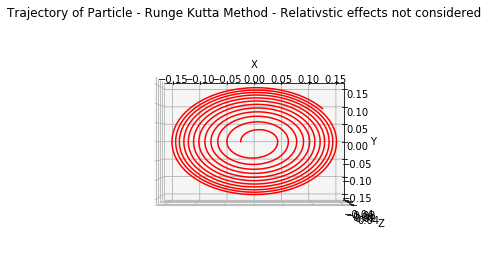

In [300]:
#Trajectory to show behaviour of nucleus. This angle is used since there is no motion in the z direction. 
fig = plt.figure() 
ax = plt.gca(projection='3d')
ax.view_init(90,-90)
ax.plot(trajectory_cyclotron_nonrel[:50000,0],trajectory_cyclotron_nonrel[:50000,1],
        trajectory_cyclotron_nonrel[:50000,2], color = 'red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.suptitle('Trajectory of Particle - Runge Kutta Method - Relativstic effects not considered')

Text(0, 0.5, 'Kinetic Energy (J)')

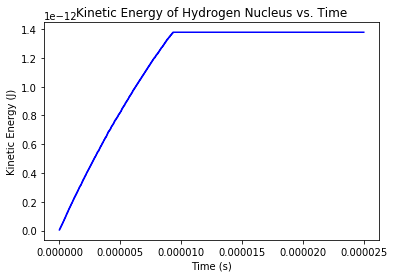

In [301]:
#PLotting K.E vs Time of particle.
plt.plot(timesteps, kinetic_nonrel, color = 'blue')
plt.title('Kinetic Energy of Hydrogen Nucleus vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Kinetic Energy (J)')

Text(0, 0.5, 'Kinetic Energy (J)')

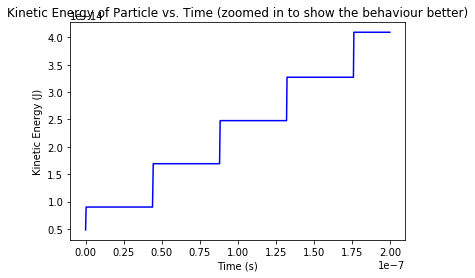

In [302]:
#same graph as before, only less timesteps considered
plt.plot(timesteps[:10000], kinetic_nonrel[:10000], color = 'blue')
plt.title('Kinetic Energy of Particle vs. Time (zoomed in to show the behaviour better)')
plt.xlabel('Time (s)')
plt.ylabel('Kinetic Energy (J)')

Text(0, 0.5, 'Electric Field Strength (N/C)')

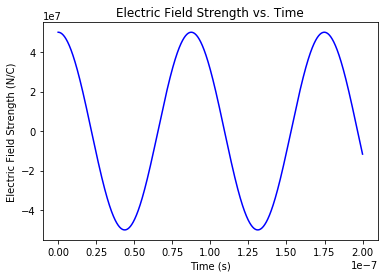

In [303]:
#Alternating E-field graphed for the same timesteps as K.E above, to show how K.E increases in the peak points
#of the E-Field graph
electric_field = np.array([])
for i in range (0,10000):
    t = timesteps[i]
    efield = E0*np.cos(w*t)
    electric_field = np.append(electric_field,efield)
    
plt.plot(timesteps[:10000], electric_field[:10000], color = 'blue')
plt.title('Electric Field Strength vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Electric Field Strength (N/C)')

Text(0, 0.5, 'Speed (m/s)')

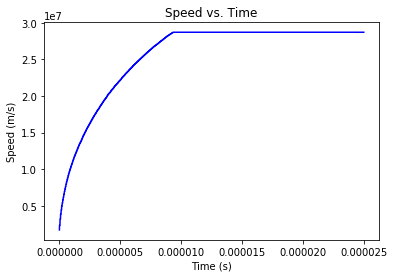

In [305]:
#Speed vs time - The flat region is after the particle has left the cyclotron, since it has achieved a speed high
#enough for the radius of circular motion to be greater than the radius of the D plates of the cyclotron. 
plt.plot(timesteps, speed_nonrel, color = 'blue')
plt.title('Speed vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')

In [330]:
#Intitial Conditions for the simulation of an electron in a cyclotron:
m = 9.11e-31  #mass of electron

q = -1.602e-19 #charge of electron

B0 = 1.5 #mag field strength in cyclotron

initial_energy = 3*1.602e-19    #This is set to have approx the same initial speed as for the hydrogen nucleus in
                                #above simulation
                                #since an initial speed is 
                                #required for the particle in a cyclotron.
            
initial_speed = ((2*initial_energy)/m)**0.5 #speed calculated using kinetic energy defined above.

initial_R = (m*initial_speed)/(q*B0) #Initial Radius of circular motion of the electron - based on intial
                                     #speed


electric_pd = 5e+1 #This is set much lower than in the case for the hydrogen nucleus since the same Potential 
                    #difference as for the hydrogen nucleus results in an unrealistically high acceleration for the
                    #electron, since its mass is much lower. 
d = 0.0000001  #gap length between the 2 D plates of cyclotron

E0 = electric_pd/d #Maximum electric field strength, calculated using eqn defined in background section, V = Ed

w = (q*B0)/m #Angular velocity of nucleus in D plates, given by eqn defined in background


In [331]:
initial_position = np.array([-initial_R,0,0])     #Set using radius of circular path defined by initial speed.
initial_velocity = np.array([0,-initial_speed,0])  #Along the y-direction - opposite to the direction of initial 
                                                   #E-field, since an electron accelerates in the opposite direction
                                                   #as the direction of the electric field
dt = 1e-9/100000                                  # set after troubleshooting and finding suitable dt
timesteps = np.arange(0, 1e-9, dt)

In [332]:
#Trajectory of hydrogen nucleus calculated using non-relativstic function
trajectory_cyclotron_rel, velocity_cyclotron_rel, kinetic_rel, speed_rel = calc_trajectory_in_fields_relativity(
                                                                        cyclotron_electric_field, 
                                                                        cyclotron_magnetic_field, 
                                                                        get_rates_of_change_runge_kutta, timesteps, 
                                                                        initial_position, initial_velocity, q, m, w, 
                                                                        E0, B0, d)

Text(0.5, 0.98, 'Trajectory of Particle - Runge Kutta Method - Relativstic effects considered')

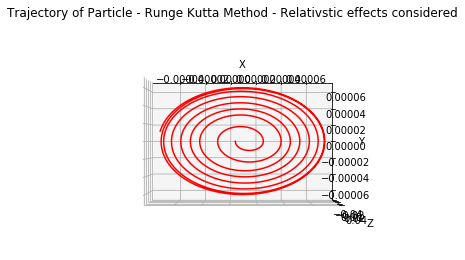

In [333]:
#Trajectory to show behaviour of nucleus. This angle is used since there is no motion in the z direction. 
fig = plt.figure() 
ax = plt.gca(projection='3d')
ax.view_init(90,-90)
ax.plot(trajectory_cyclotron_rel[:20000,0],trajectory_cyclotron_rel[:20000,1],trajectory_cyclotron_rel[:20000,2], 
        color = 'red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.suptitle('Trajectory of Particle - Runge Kutta Method - Relativstic effects considered')

Text(0, 0.5, 'Speed (m/s)')

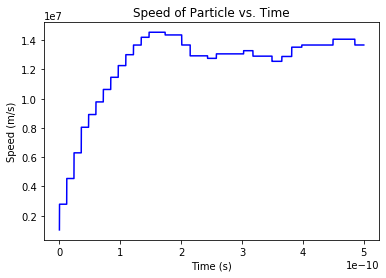

In [334]:
plt.plot(timesteps[:50000], speed_rel[:50000], color = 'blue')
plt.title('Speed of Particle vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')

#Analysis done in main write up

Text(0, 0.5, 'Kinetic Energy (J)')

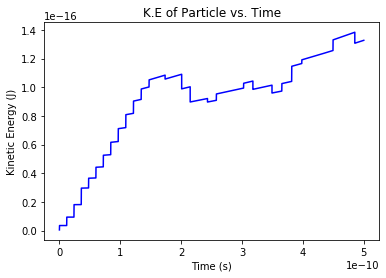

In [344]:
plt.plot(timesteps[:50000], kinetic_rel[:50000], color = 'blue')
plt.title('K.E of Particle vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Kinetic Energy (J)')


In [335]:
#Intitial Conditions same as above for electron: This is to simulate trajectory without considering relativistic 
#effects
m = 9.11e-31
q = -1.602e-19
B0 = 1.5
initial_energy = 3*1.602e-19
initial_speed = ((2*initial_energy)/m)**0.5
initial_R = (m*initial_speed)/(q*B0)
final_energy = 15e+6*1.602e-19
electric_pd = 5e+1
d = 0.0000001

E0 = electric_pd/d
w = (q*B0)/m
final_speed = ((2*final_energy)/m)**0.5

energy_step = electric_pd*q
speed_step = ((2*energy_step)/m)**0.5
n_of_crossings = (final_energy-initial_energy)/energy_step
T = 2*np.pi/w
total_time = T*n_of_crossings

In [336]:
#Same as for previous case
initial_position = np.array([-initial_R,0,0])
initial_velocity = np.array([0,-initial_speed,0])
dt = 1e-9/100000
timesteps = np.arange(0, 1e-9, dt)

In [337]:
trajectory_e_cyclotron_nonrel, velocity_e_cyclotron_nonrel, kinetic_e_nonrel, speed_e_nonrel = calc_trajectory_in_fields(
                                                                cyclotron_electric_field, 
                                                                cyclotron_magnetic_field, 
                                                                get_rates_of_change_runge_kutta, timesteps, 
                                                                initial_position, initial_velocity, q, m, w, 
                                                                E0, B0, d)

Text(0.5, 0.98, 'Trajectory of Particle - Runge Kutta Method')

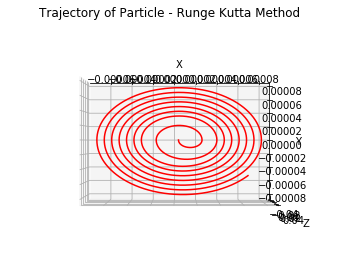

In [338]:
#Trajectory to show behaviour of nucleus. This angle is used since there is no motion in the z direction. 
fig = plt.figure() 
ax = plt.gca(projection='3d')
ax.view_init(90,-90)
ax.plot(trajectory_e_cyclotron_nonrel[:20000,0],trajectory_e_cyclotron_nonrel[:20000,1],trajectory_e_cyclotron_nonrel[:20000,2], color = 'red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.suptitle('Trajectory of Particle - Runge Kutta Method')

Text(0, 0.5, 'Speed')

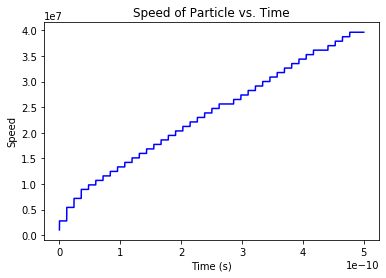

In [339]:
plt.plot(timesteps[:50000], speed_e_nonrel[:50000], color = 'blue')
plt.title('Speed of Particle vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Speed')
#Analysis done in main write up

Text(0, 0.5, 'Kinetic Energy (J)')

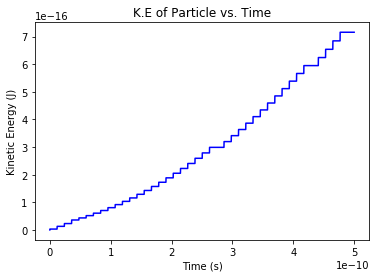

In [343]:
plt.plot(timesteps[:50000], kinetic_e_nonrel[:50000], color = 'blue')
plt.title('K.E of Particle vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Kinetic Energy (J)')
#Analysis done in main write up